In [1]:
import serial
from collections import Counter
import json

# Step 1: Data collecting

In [2]:
ser = serial.Serial('/dev/ttyACM0', baudrate=115200, )

##### need to skip intro message

In [3]:
print ser.readline()

Started!



In [47]:
nothing = 'white'
red = 'red'
blue = 'blue'
brown = 'brown'
green = 'green'
yellow = 'yellow'
orange = 'orange'

In [5]:
from tqdm import tqdm_notebook
import pandas as pd

In [188]:
dims_number = 4

In [6]:
def read_n_samples(expected_class, N, serial=ser):
    res = []
    serial.flushInput()
    for _ in tqdm_notebook(range(N), desc='Reading %s...'%expected_class):
        r, g, b, c, _ = map(int, ser.readline().split(' '))
        res.append([expected_class, r, g, b, c])
    
    pd_res = pd.DataFrame(res, columns=['class', 'R', 'G', 'B', 'C'])
    return pd_res

In [11]:
all_data = pd.DataFrame()

In [ ]:
a = read_n_samples(brown, 5)

In [33]:
a = read_n_samples(yellow, 5)

In [46]:
a = read_n_samples(green, 5)

In [68]:
a = read_n_samples(orange, 5)

In [ ]:
a = read_n_samples(blue, 5)

In [84]:
a = read_n_samples(red, 5)

In [96]:
a = read_n_samples(nothing, 5)

In [97]:
a

,class,R,G,B,C
0,white,37900,30570,37100,107260
1,white,35430,28080,33960,96710
2,white,35430,28450,34470,99960
3,white,35210,28240,34260,99360
4,white,34540,27790,34770,101700


In [98]:
all_data = all_data.append(a)
print 'Total now: %d'%all_data.shape[0]
print 'Available classes: %s'%(json.dumps(Counter(all_data['class']), indent=4))

Total now: 125
Available classes: {
    "blue": 25, 
    "yellow": 20, 
    "green": 20, 
    "orange": 20, 
    "white": 20, 
    "red": 20
}


In [200]:
all_data.to_csv('box_sensor.csv')

In [137]:
ser.close()

# Step2: Lets observe data 

In [ ]:
all_data = pd.read_csv('box_sensor.csv')

In [189]:
import seaborn as sns

%matplotlib inline

In [190]:
from sklearn.decomposition import PCA

In [191]:
projector = PCA(2)

In [198]:
xys = projector.fit_transform(all_data.iloc[:, -dims_number:])

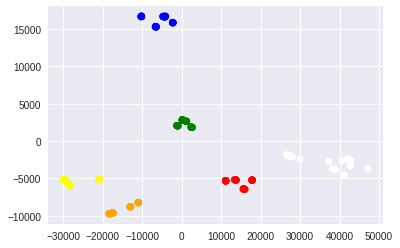

In [199]:
sns.plt.scatter(xys[:, 0], xys[:, 1], c=all_data['class'])

## Okay, it seems to be linear solvable

# Step 3: building a classifier

In [106]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [124]:
cls = Pipeline([('scaler', StandardScaler()),
                ('svm', OneVsRestClassifier(SVC(kernel='linear', probability=True)))])

In [125]:
cls.fit(all_data.iloc[:, -4:], all_data['class'])

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1))])

## Lets observe params of classifier

In [126]:
scaler = cls.steps[0][1]
classifier = cls.steps[1][1]

In [138]:
scaler.mean_

array([  48569.2 ,   38272.4 ,   45261.36,  133028.24])

In [140]:
scaler.scale_

array([ 10044.10327307,   5813.49153607,   7281.40957167,  16919.89305233])

In [127]:
for name, est in zip(classifier.classes_, classifier.estimators_):
    print name, est.intercept_, est.coef_

blue [-1.02145308] [[-0.40474246 -0.18890822  0.99604166  0.1847302 ]]
green [-1.87139226] [[-1.96081618  3.85329774 -0.99640643 -1.62411197]]
orange [-2.44155463] [[ 2.43327866 -2.0819878   0.27706819  0.78752813]]
red [-2.08618774] [[ 1.67598532 -3.40039139  2.28610403 -0.64856683]]
white [-2.92653898] [[-1.98360981  0.03685838 -0.44829316 -1.13028324]]
yellow [-2.3484152] [[ 0.18819443  2.01927025 -0.14062996  0.81261244]]


## Okay. Seems reasonable

## There we can to try classifier in realtime
Moreover, we check if we can replay classifiers behaviour with simple math with given parameters.

In [128]:
import numpy as np

In [129]:
N=100
ser.flushInput()
print cls.classes_
for _ in tqdm_notebook(range(N)):
    r,g,b, c, _ = map(int, ser.readline().split(' '))

    print (cls.predict(np.matrix([[r, g, b, c]])), cls.decision_function(np.matrix([[r, g, b, c]])))
    
    rgb = ((np.matrix([[r,g,b, c]])) - scaler.mean_) / scaler.scale_
    my_decision_func = max([(name, est.intercept_ + np.dot(rgb, est.coef_.T)) 
           for name, est in zip(classifier.classes_, classifier.estimators_)], key=lambda (x,y): y)
    print my_decision_func


['blue' 'green' 'orange' 'red' 'white' 'yellow']


(array(['white'], 
      dtype='|S6'), array([[-1.56961   , -1.42200549, -3.63499001, -1.06636599,  0.76684373,
        -5.73787204]]))
('white', matrix([[ 0.76684373]]))
(array(['white'], 
      dtype='|S6'), array([[-1.56926378, -1.42161002, -3.63288016, -1.06612154,  0.76167364,
        -5.73373675]]))
('white', matrix([[ 0.76167364]]))
(array(['blue'], 
      dtype='|S6'), array([[ 1.00106487, -2.32721116, -3.72355562, -0.27302997, -2.66218164,
        -2.12293581]]))
('blue', matrix([[ 1.00106487]]))
(array(['blue'], 
      dtype='|S6'), array([[ 1.32899941, -0.96754178, -4.76258424, -1.08190044, -2.53015053,
        -1.40980156]]))
('blue', matrix([[ 1.32899941]]))

(array(['blue'], 
      dtype='|S6'), array([[ 1.32114099, -0.94484783, -4.776608  , -1.06707723, -2.49537746,
        -1.44076878]]))
('blue', matrix([[ 1.32114099]]))
(array(['white'], 
      dtype='|S6'), array([[-1.55745953, -1.42606802, -3.60836942, -1.09468579,  0.67727225,
        -5.6534037 ]]))
('white', matr

KeyboardInterrupt: 

# Step 4: Things are gonna become strange
We want to use classifier on 8bit Arduino-microcontroller

### Okay, lets generate the code to apply our model

#### One SVM unit computation

In [174]:
def generate_decision_function(classname, class_id, svm, scaler, variables = ['r', 'g', 'b']):
    
    input_args = ', '.join(['float %s'%var for var in variables])
    
    scaled_vars = (['((float)%s - %s)/%s'%(var, m, s) 
                    for var, m, s in zip(variables, scaler.mean_, scaler.scale_)])
    
    multiplied_vars = ' \n\t\t+ '.join(['(%s)*(%s)'%(scaled, v) for scaled, v in zip(scaled_vars, svm.coef_[0])])
    
    body = '''float check_if_it_is_{classname}_object({income_vars})
    {{
        return {w} + {multiplied_vars};
    }}'''
    
    return body.format(classname=classname, income_vars=input_args, multiplied_vars=multiplied_vars, w=svm.intercept_[0])

#### Thing which choose the best class by application all of SVMs

In [182]:
def generate_maximizer(classnames, variables):
    
    input_args = ', '.join(['float %s'%var for var in variables])
    passing_args = ', '.join(variables)
    
    if_template = '''        value = check_if_it_is_{classname}_object({passing_args});
        if (value > max_value)
        {{
            max_id = {current_id};
            max_value = value;
        }}
    '''
    
    ifs = '\n'.join(
        [if_template.format(classname=name, passing_args=passing_args, current_id=i) 
             for i, name in enumerate(classnames)])
    
    
    body = '''int make_a_decision({input_args})
    {{
        int max_id = 0;
        float max_value = -10000;
        float value;
{ifs}
        return max_id;
    }}
    '''
    
    return body.format(input_args=input_args, ifs=ifs)

#### Some usability stuff

In [183]:
def generate_defines(classnames):
    return '\n'.join(['#define\t%15s\t%2d'%(n, i) for (i, n) in enumerate(classnames)])

In [184]:
def generate_all_decisions(classnames, svms, scaler, variables = ['r', 'g', 'b']):
    res = []
    for i, (est, classname) in enumerate(zip(svms, classnames)):
        res.append(generate_decision_function(classname, i, est, scaler, variables=variables))
    return '\n\n'.join(res)

In [185]:
def generate_all(pipeline, variables='rgb'):
    scaler = pipeline.steps[0][1]
    classifier = pipeline.steps[1][1]
    
    return '\n\n'.join([  generate_defines(list(pipeline.classes_)),
                        generate_all_decisions(pipeline.classes_, classifier.estimators_, scaler, variables),
                        generate_maximizer(pipeline.classes_, variables)])
    

In [186]:
with open('classifier.h', 'w') as outcome:
    outcome.write(generate_all(cls, 'rgbc'))

#### To check if our generated code even compiles

In [187]:
!gcc classifier.h